In [23]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
import jax
import jax.numpy as jnp
import multiprocessing as mp
from itertools import product
from matplotlib import collections as matcoll
from sklearn.model_selection import train_test_split, KFold
from scipy.io import savemat, loadmat
import optax

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def activation_probs(x, w):
    # w : site weights, n x d
    # x : current levels, c x d
    site_activations = jnp.dot(w, jnp.transpose(x)) # dimensions: n x c
    p_sites = jax.nn.sigmoid(site_activations) # dimensions : n x c
    p = 1 - jnp.prod(1 - p_sites, 0)  # dimensions: c

    return p

In [3]:
def neg_log_likelihood(w, X, y, l2_reg=0):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # trials: number of trials at each current level, c
    # l2_reg: l2 regularization penalty
    # w = w.reshape(-1, x.shape[-1])  # dimensions: n x d
    
    # Get predicted probability of spike using current parameters
    yPred = activation_probs(X, w)
    yPred = jnp.clip(yPred, a_min=1e-5, a_max=1-1e-5)

    NLL = -jnp.sum(y * jnp.log(yPred) + (1 - y) * jnp.log(1 - yPred)) / len(X)   # negative log likelihood for logistic

    penalty = l2_reg/2 * jnp.linalg.norm(w)**2
    # print(NLL, penalty)

    return NLL + penalty

In [4]:
def optimize_w(w, X, y, l2_reg=0, zero_prob=0.01, step_size=0.0001, n_steps=100, wtol=5e-5, step_cnt_decrement=5):

    m = len(w)
    z = 1 - (1 - zero_prob)**(1/m)

    @jax.jit
    def update(w, X, y, l2_reg):
        grads = jax.grad(neg_log_likelihood)(w, X, y, l2_reg=l2_reg)
        return grads

    losses = []
    prev_w = w
    for step in range(n_steps):
        grad = update(w, X, y, l2_reg)
        w = w - step_size * grad
        losses += [neg_log_likelihood(w, X, y, l2_reg=l2_reg)]
        w = w.at[:, 0].set(jnp.minimum(w[:, 0], np.log(z/(1-z))))

        # print(step, jnp.linalg.norm(w - prev_w) / len(w.ravel()), jnp.linalg.norm(grad) / len(w.ravel()))
        if jnp.linalg.norm(w - prev_w) / len(w.ravel()) <= wtol:
            break
        prev_w = w
        
    return losses, w

In [5]:
selectivities_full = np.load('selectivities_full.npy').tolist()
selectivities_active = np.load('selectivities_active.npy').tolist()
datasets = np.load('datasets.npy', allow_pickle=True).tolist()

In [6]:
plt.close('all')

In [7]:
# def fit_surface_CV(X, probs, T, ms, folds=5, l2_reg=0.01, w_step_size=0.0001, n_steps=3500, plot=False, random_state=None):
#     w_inits = []
#     for m in ms:
#         w_init = jnp.array(np.random.normal(size=(m, X.shape[1])))
#         w_inits.append(w_init)

#     kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
#     ms_kfold = []

#     for train_inds, test_inds in kf.split(X):
#         RMSEs = np.zeros(len(ms))
#         for i in range(len(ms)):
#             losses, w_final = optimize_w(X[train_inds], w_inits[i], probs[train_inds], T[train_inds], l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)

#             p_pred = activation_probs(X[test_inds], w_final)
#             RMSE = jnp.sqrt(jnp.sum((p_pred - probs[test_inds])**2) / len(test_inds))
#             RMSEs[i] = RMSE

#         chosen_m = np.argmin(RMSEs)
#         ms_kfold.append(chosen_m)

#     m_final = np.round(np.mean(np.array(ms_kfold))).astype(int)
#     losses, w_final = optimize_w(X, w_inits[m_final], probs, T, l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)
    
#     if plot:
#         print(ms[m_final])
#         p_pred_all = activation_probs(X_all, w_final)
#         fig = plt.figure()
#         fig.clear()
#         ax = Axes3D(fig, auto_add_to_figure=False)
#         fig.add_axes(ax)
#         plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
#         plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
#         plt.xlim(-1.8, 1.8)
#         plt.ylim(-1.8, 1.8)
#         ax.set_zlim(-1.8, 1.8)
#         ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

#         scat = ax.scatter(X_all[:, 1], 
#                     X_all[:, 2],
#                     X_all[:, 3], marker='o', c=p_pred_all, s=20, alpha=0.8, vmin=0, vmax=1)

#         plt.show()

#         plt.figure()
#         plt.plot(losses)
#         plt.show()

#         fig = plt.figure()
#         fig.clear()
#         ax = Axes3D(fig, auto_add_to_figure=False)
#         fig.add_axes(ax)
#         plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
#         plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
#         plt.xlim(-1.8, 1.8)
#         plt.ylim(-1.8, 1.8)
#         ax.set_zlim(-1.8, 1.8)
#         ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

#         scat = ax.scatter(X[:, 1], 
#                     X[:, 2],
#                     X[:, 3], marker='o', c=probs, s=20, alpha=0.8, vmin=0, vmax=1)

#         plt.show()

#     return w_final

In [8]:
def fit_surface_ttsplit(X, y, ms, train_size=0.8, l2_reg=0.01, w_step_size=0.0001, n_steps=3500, plot=False, random_state=None):
    w_inits = []
    for m in ms:
        w_init = jnp.array(np.random.normal(size=(m, X.shape[1])))
        w_inits.append(w_init)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
    RMSEs = np.zeros(len(ms))
    for i in range(len(ms)):
        losses, w_final = optimize_w(w_inits[i], X_train, y_train, l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)

        y_pred = activation_probs(X_test, w_final)
        RMSE = jnp.sqrt(jnp.sum((y_pred - y_test)**2) / len(y_test))
        print(RMSE, losses[-1])
        RMSEs[i] = RMSE

    m_final = np.argmin(RMSEs)
    losses, w_final = optimize_w(w_inits[m_final], X, y, l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)
    
    if plot:
        print(ms[m_final])
        p_pred_all = activation_probs(X_all, w_final)
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_all[:, 1], 
                    X_all[:, 2],
                    X_all[:, 3], marker='o', c=p_pred_all, s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        plt.figure()
        plt.plot(losses)
        plt.show()

        # fig = plt.figure()
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X[:, 1], 
        #             X[:, 2],
        #             X[:, 3], marker='o', c=probs, s=20, alpha=0.8, vmin=0, vmax=1)

        # plt.show()

    return w_final

In [9]:
def fit_surface_BIC(X, y, ms, l2_reg=0.01, w_step_size=0.0001, n_steps=3500, plot=False, random_state=None):
    w_inits = []
    for m in ms:
        w_init = jnp.array(np.random.normal(size=(m, X.shape[1])))
        w_inits.append(w_init)

    BICs = np.zeros(len(ms))
    for i in range(len(ms)):
        losses, w_final = optimize_w(w_inits[i], X, y, l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)

        BIC = len(w_final.ravel()) * jnp.log(len(X)) + 2 * losses[-1]
        print(BIC)
        BICs[i] = BIC

    m_final = np.argmin(BICs)
    losses, w_final = optimize_w(w_inits[m_final], X, y, l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)
    
    if plot:
        print(ms[m_final])
        p_pred_all = activation_probs(X_all, w_final)
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_all[:, 1], 
                    X_all[:, 2],
                    X_all[:, 3], marker='o', c=p_pred_all, s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        plt.figure()
        plt.plot(losses)
        plt.show()

        # fig = plt.figure()
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X[:, 1], 
        #             X[:, 2],
        #             X[:, 3], marker='o', c=probs, s=20, alpha=0.8, vmin=0, vmax=1)

        # plt.show()

    return w_final

In [10]:
# Path definitions
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = None

dataset = "2020-10-06-7"
estim = "data003/data003-all"
wnoise = "kilosort_data000/data000"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)

# ms = [2, 3, 4, 5]
# l2_reg = 0.01
# w_step_size = 1
# folds = 5
# n_steps = 3500
# train_size = 0.8

method = 'L-BFGS-B'
jac = fitting.negLL_hotspot_jac
l2_reg = 0.1

p = 2
cells = np.array([259, 292])

ws = []
for cell in cells:

    X_expt_orig, probs_orig, T_orig = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, cell,
                                            load_from_mat=True, 
                                            MATFILE_BASE=MATFILE_BASE)

    # X_all = jnp.array(sm.add_constant(mutils.get_stim_amps_newlv(electrical_path, p), has_constant='add'))
    X_expt, probs, T = mutils.triplet_cleaning(X_expt_orig, probs_orig, T_orig, electrical_path, p)
    weights_cell = jnp.array(fitting.fit_triplet_surface(X_expt, probs, T, method=method, jac=jac, starting_m=2, max_sites=5, reg_method='l2', 
                                          reg=l2_reg))
    # X_bin, y_bin = fitting.convertToBinaryClassifier(probs, T, X_expt)
    # X_bin = jnp.array(X_bin)
    # y_bin = jnp.array(y_bin)
    
    # weights_cell = fit_surface_CV(X, probs, T, ms, folds=folds, l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True)
    # weights_cell = fit_surface_ttsplit(X_bin, y_bin, ms, train_size=train_size, l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True)
    # weights_cell = fit_surface_BIC(X_bin, y_bin, ms, l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True)

    ws.append(weights_cell)

X_expt_orig = mutils.get_stim_amps_newlv(electrical_path, p)
w_true_t = ws[0]
w_true_nt = ws[1]

X = jnp.array(X_expt_orig)
p_true_t = activation_probs(sm.add_constant(X, has_constant='add'), w_true_t) # prob with each current level
p_true_nt = activation_probs(sm.add_constant(X, has_constant='add'), w_true_nt) # prob with each current level

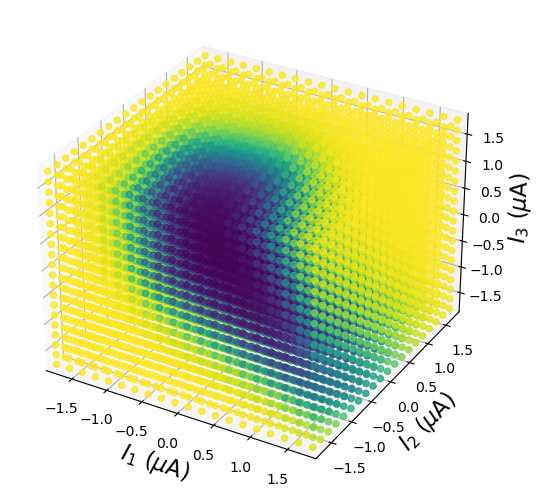

In [11]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=p_true_t, s=20, alpha=0.8, vmin=0, vmax=1)

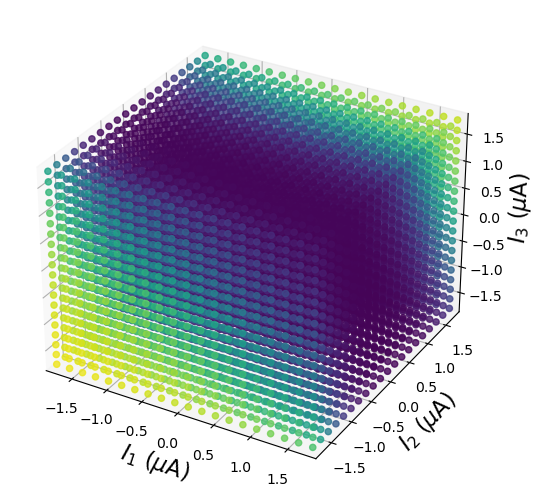

In [12]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=p_true_nt, s=20, alpha=0.8, vmin=0, vmax=1)

In [13]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    return p_empirical

In [14]:
def fisher_info(x, w, t):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # t: number of trials for each current level, c
    
    p_model = jnp.clip(activation_probs(x, w), a_min=1e-5, a_max=1-1e-5) # c
    I_p = jnp.diag(t / (p_model * (1 - p_model)))   # c x c
    J = jax.jacfwd(activation_probs, argnums=1)(x, w).reshape((len(x), w.shape[0]*w.shape[1]))
    I_w = jnp.dot(jnp.dot(J.T, I_p), J) / len(x)
    
    loss = jnp.trace(J @ (jnp.linalg.inv(I_w) @ J.T))
    # sign, logdet = jnp.linalg.slogdet(I_w)
    # loss = -sign * logdet
    return loss

In [30]:
def optimize_fisher(x, w_t, w_nt, t_prev, t, reg=0, step_size=0.001, n_steps=100, reltol=-np.inf, T_budget=5000, step_cnt_decrement=5):

    optimizer = optax.adam(step_size)
    opt_state = optimizer.init(t)

    @jax.jit
    def update(x, w_t, w_nt, t_prev, t):
        # fisher_lambda = lambda t, x, w_t, w_nt, t_prev: fisher_info(x, w_t, t_prev + jnp.absolute(t)) + fisher_info(x, w_nt, t_prev + jnp.absolute(t)) + reg * jnp.absolute(jnp.sum(jnp.absolute(t)) - T_budget)
        fisher_lambda = lambda t, x, w_t, w_nt, t_prev: fisher_info(x, w_t, t_prev + jnp.absolute(t)) + fisher_info(x, w_nt, t_prev + jnp.absolute(t))  + reg * jnp.sum(jnp.absolute(t))
        grads = jax.grad(fisher_lambda)(t, x, w_t, w_nt, t_prev)

        return grads
    
    losses = []
    for step in range(n_steps):
        grads = update(x, w_t, w_nt, t_prev, t)
        updates, opt_state = optimizer.update(grads, opt_state)
        t = optax.apply_updates(t, updates)
        # grad = update(x, w_t, w_nt, t_prev, t)
        # t = t - step_size * grad
    
        losses += [[fisher_info(x, w_t, t_prev + jnp.absolute(t)) + fisher_info(x, w_nt, t_prev + jnp.absolute(t)), 
                    jnp.sum(jnp.absolute(t)),
                    fisher_info(x, w_t, t_prev + jnp.absolute(t)) + fisher_info(x, w_nt, t_prev + jnp.absolute(t)) + reg * jnp.sum(jnp.absolute(t))]]
                    # fisher_info(x, w_t, t_prev + jnp.absolute(t)) + fisher_info(x, w_nt, t_prev + jnp.absolute(t)) + reg * jnp.absolute(jnp.sum(jnp.absolute(t)) - T_budget)]]
        
        # if step % step_cnt_decrement == 0:
        #     step_size = step_size * 0.95

    return np.array(losses), t

In [44]:
def binary_search_fisher(reg_array, low, high, x, w_t, w_nt, t_prev, t, T_budget, budget_tol=0.1, step_size=0.001, n_steps=100):
    losses, t = optimize_fisher(x, w_t, w_nt, t_prev, t, reg=reg_array[high], step_size=step_size, n_steps=n_steps)
    budget_high = jnp.sum(jnp.absolute(t))
    print(reg_array[high], budget_high)

    if budget_high <= (1 + budget_tol) * T_budget and budget_high >= (1 - budget_tol) * T_budget:
        return losses, t, high

    losses, t = optimize_fisher(x, w_t, w_nt, t_prev, t, reg=reg_array[low], step_size=step_size, n_steps=n_steps)
    budget_low = jnp.sum(jnp.absolute(t))
    print(reg_array[low], budget_low)

    if budget_low <= (1 + budget_tol) * T_budget and budget_low >= (1 - budget_tol) * T_budget:
        return losses, t, low

    if (budget_high > T_budget and budget_low < T_budget) or (budget_high < T_budget and budget_low > T_budget):
        mid = (high + low) // 2

        losses, t = optimize_fisher(x, w_t, w_nt, t_prev, t, reg=reg_array[mid], step_size=step_size, n_steps=n_steps)
        budget_mid = jnp.sum(jnp.absolute(t))
        print(reg_array[mid], budget_mid)
        if budget_mid <= (1 + budget_tol) * T_budget and budget_mid >= (1 - budget_tol) * T_budget:
            return losses, t, mid

        elif budget_mid > T_budget:
            return binary_search_fisher(reg_array, low+1, mid-1, x, w_t, w_nt, t_prev, t, T_budget, budget_tol=budget_tol, step_size=step_size, n_steps=n_steps)
        
        else:
            return binary_search_fisher(reg_array, mid+1, high-1, x, w_t, w_nt, t_prev, t, T_budget, budget_tol=budget_tol, step_size=step_size, n_steps=n_steps)

    else:
        print("not found")
        return -1

In [47]:
def get_performance_AL(X, w_meas, p_true):
    probs_pred = activation_probs(X, w_meas)
    RMSE = jnp.sqrt(jnp.sum((probs_pred - p_true)**2) / len(X))

    return RMSE

Restart 1


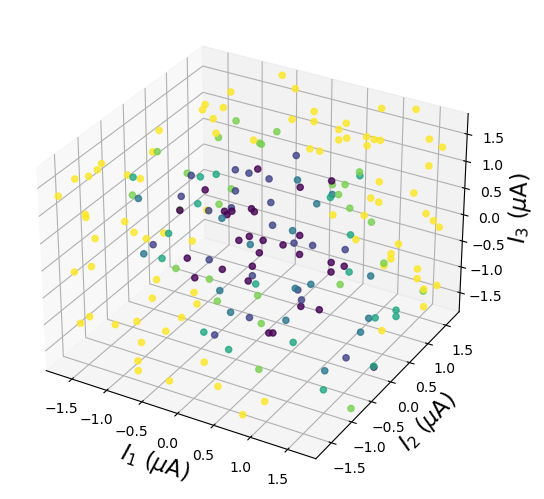

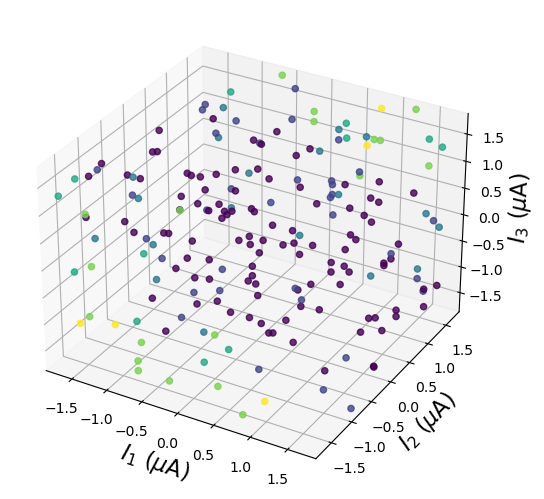

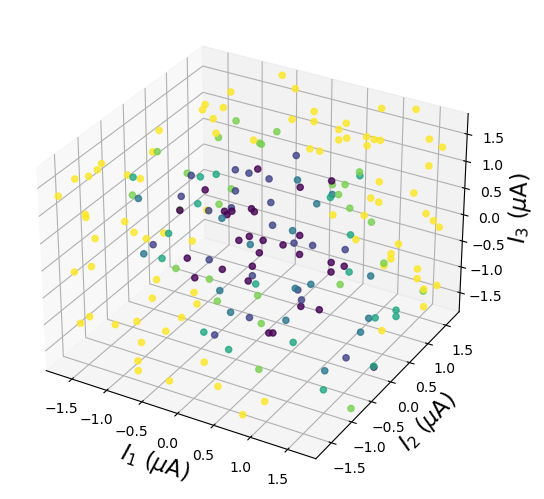

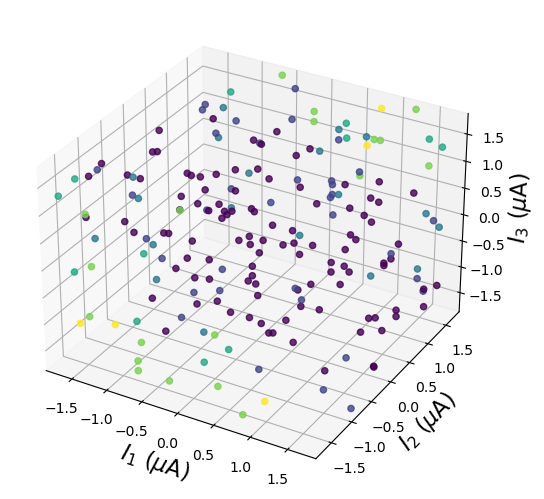

[[-5.985187    5.148136    2.522816    1.7909524 ]
 [-5.985187   -2.1238863  -2.8776813  -4.3757777 ]
 [-5.985187   -1.0466137   2.3830812   3.8239315 ]
 [-5.985187   -6.054715   -1.2789663   0.08182459]]
[[-5.676133    0.36686593  2.977844    1.1515025 ]
 [-5.290783   -0.7258321  -3.4335341  -0.92587507]]
[[-5.985187    5.148136    2.522816    1.7909524 ]
 [-5.985187   -2.1238863  -2.8776813  -4.3757777 ]
 [-5.985187   -1.0466137   2.3830812   3.8239315 ]
 [-5.985187   -6.054715   -1.2789663   0.08182459]]
[[-5.676133    0.36686593  2.977844    1.1515025 ]
 [-5.290783   -0.7258321  -3.4335341  -0.92587507]]
0.060926255 0.060926255
0.02736155 0.02736155


0.03125 60789.82
32.0 1316.6741
1.0003466683266857 10756.502
1.0010403655585052 10677.07
31.97782475893881 1378.3169
5.6597960827111224 4054.5
5.663720906974105 4064.6099
31.955664884793787 1401.4014
13.453176848026068 2393.9697
13.462506045427478 2397.7031
31.933520366915946 1351.717
20.734155661405335 1800.4263


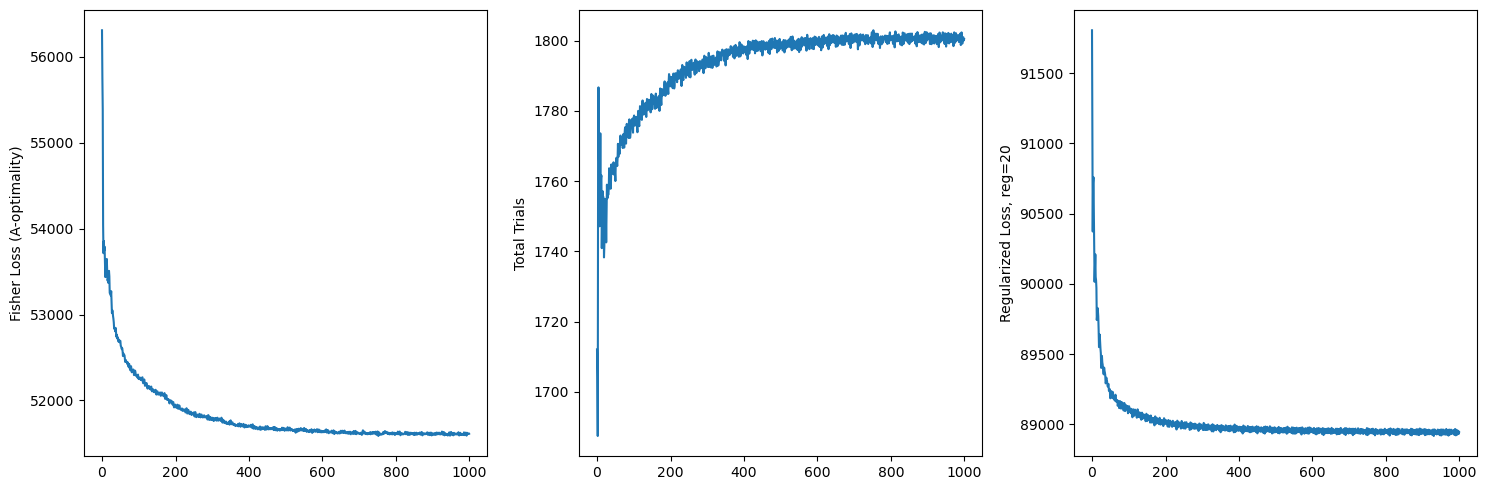

1758.0


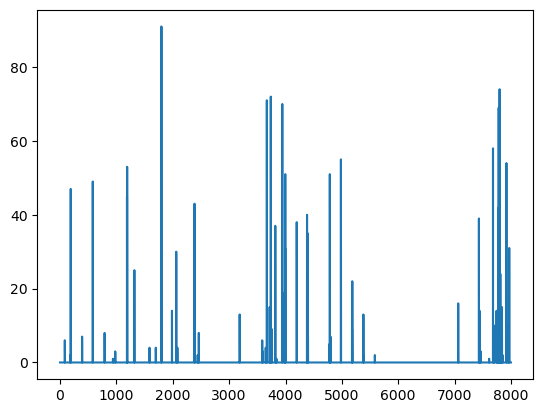

2000.0


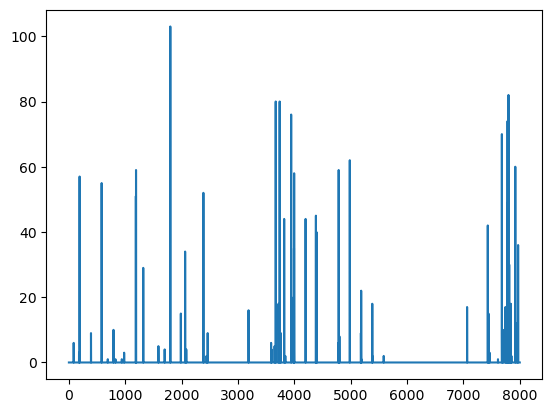

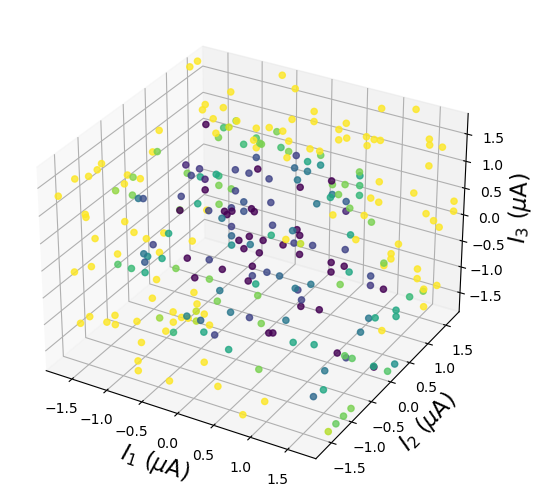

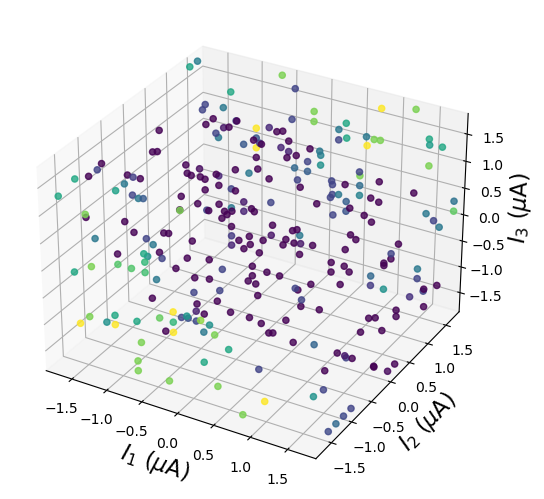

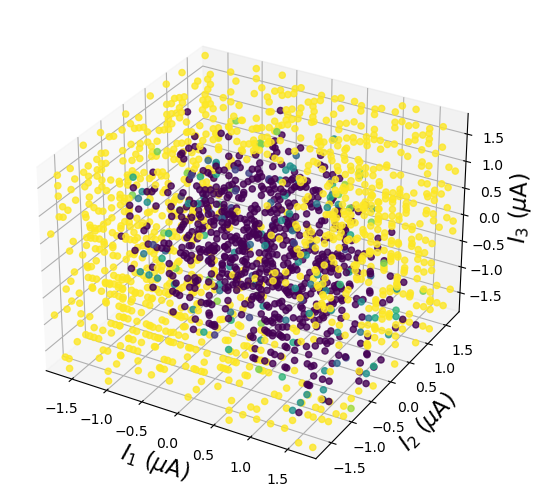

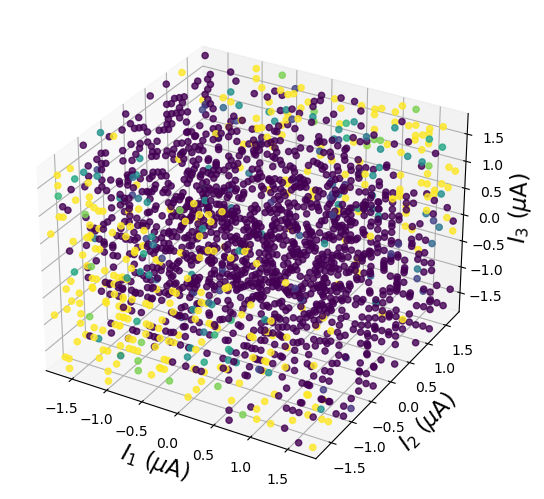

[[-6.0768723  -2.6055987  -3.2694592  -4.3665986 ]
 [-5.985187   -5.645862   -1.0992492   0.39556873]
 [-5.985187    5.3728204   1.9197661   1.7389491 ]
 [-6.251371   -0.02749445  2.9665954   3.9282184 ]]
[[-5.290783   -0.8333386  -3.3596063  -0.9906375 ]
 [-5.290783    0.49989265  2.6244538   1.0714537 ]]


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in multiply
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:88: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:115: RuntimeWarning: overflow encountered in multiply
  prod = prod * (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:127: RuntimeWarning: overflow encountered in exp
  factors[i] = factors[i] + np.exp(X @ np.sum(w[other_combo], axis=0).T)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:134: RuntimeWarning: invalid value encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:134: RuntimeWarning: overflow encountered in multiply
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes

[[-5.985187   -5.7727947  -1.2082096   0.26494515]
 [-5.985187    5.4445066   2.1825433   1.8111606 ]
 [-6.5387063  -2.3214984  -3.1571338  -4.7169237 ]
 [-6.0035458  -0.8769038   2.5280488   3.7321563 ]]
[[-5.290783   -0.8369512  -3.3343298  -0.81677544]
 [-5.290783    0.50158876  2.6614077   1.0847844 ]]
0.018998135 0.029953355
0.013403857 0.01586945


0.03125 52782.22
32.0 527.0584
1.0003466683266857 8792.927
1.0010403655585052 8771.774
31.97782475893881 344.47626
5.6597960827111224 2185.773


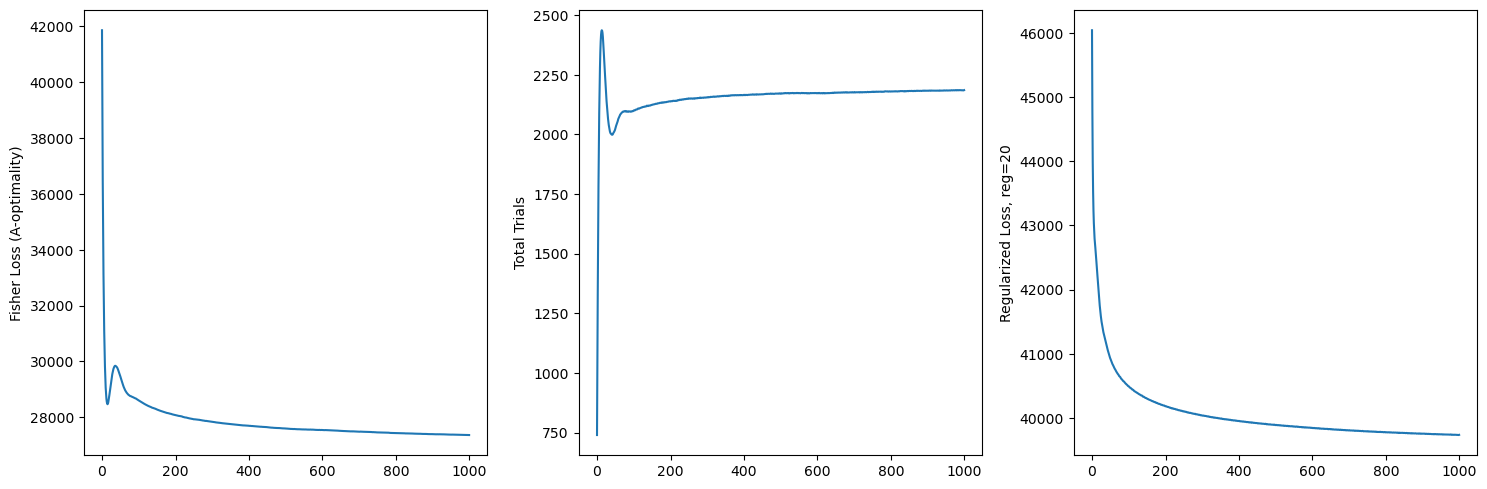

2136.0


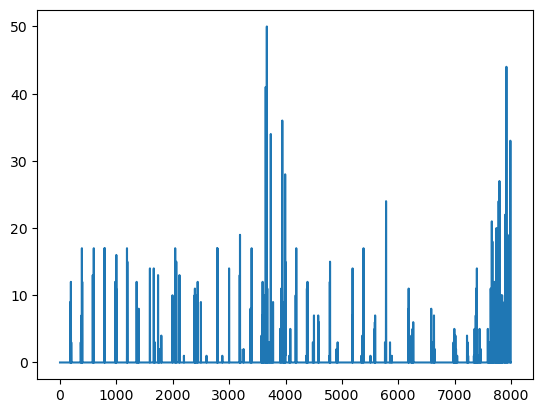

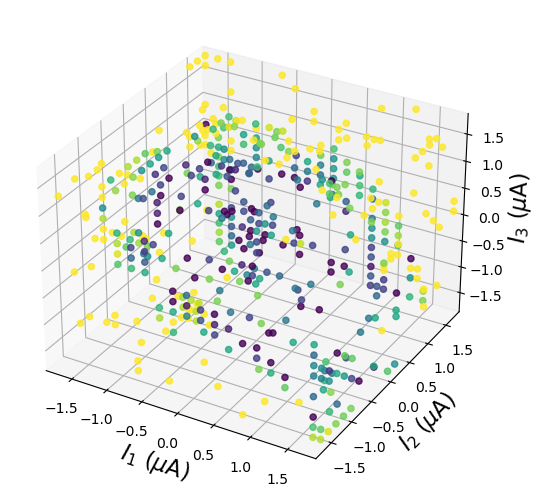

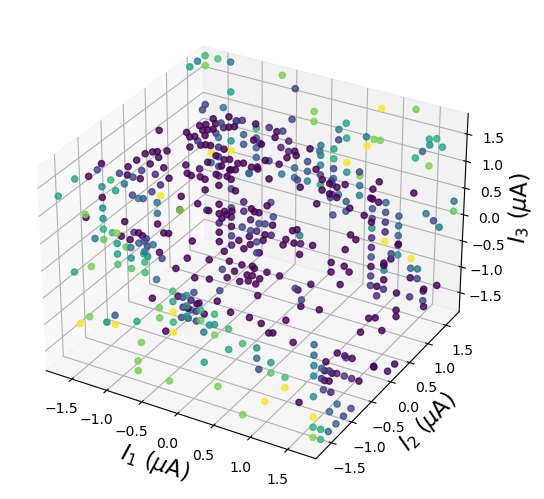

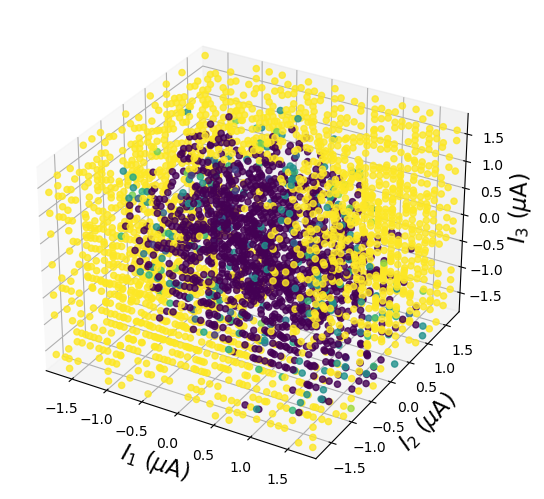

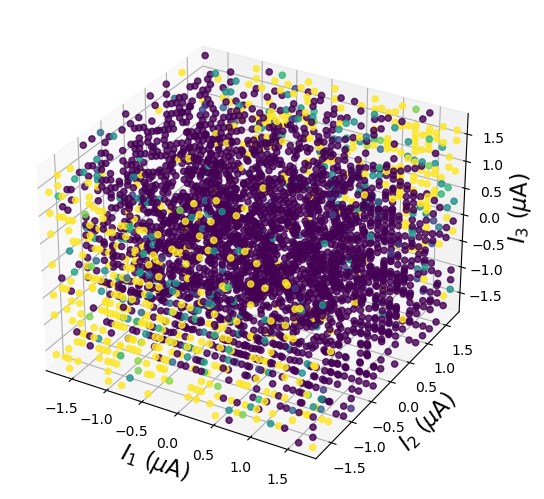

[[-6.186283   -0.17644389  2.8193986   3.8626275 ]
 [-6.7262354  -2.7226303  -3.424579   -4.854837  ]
 [-6.1656404  -5.825266   -1.2406319   0.21053457]
 [-6.0212355   5.3828974   1.9114311   1.7633483 ]]
[[-5.3808193  -0.77655613 -3.4067664  -0.974017  ]
 [-5.3556814   0.44197372  2.628009    1.1144584 ]]
[[-5.985187  -0.4401455  2.6731706  3.6730924]
 [-5.985187   5.439997   2.1179175  1.7668803]
 [-6.47265   -6.1419764 -1.2061495  0.4356848]
 [-6.1119637 -2.2668607 -3.05583   -4.438537 ]]
[[-5.290783   -0.82595503 -3.3280082  -0.8173319 ]
 [-5.290783    0.5424428   2.625226    1.0698045 ]]
0.018528027 0.026395854
0.014397232 0.014986586


0.03125 55792.453
32.0 72.723236
1.0003466683266857 6468.0107
1.0010403655585052 6536.394


KeyboardInterrupt: 

In [48]:
%matplotlib inline

total_budget = 10000
num_iters = 5
budget = int(total_budget / num_iters)
regs = np.flip(np.logspace(-5, 5, 10000, base=2))
num_restarts = 100
# w_step_size = 1
l2_reg = 0.1
T_step_size = 0.05
T_n_steps = 1000

init_size = 200
init_trials = 5

performance_stack_t = []
performance_stack_nt = []
performance_stack_random_t = []
performance_stack_random_nt = []
num_samples_stack = []

for restart in range(num_restarts):
    print('Restart', restart + 1)
    # Initialize amplitudes
    init_inds = np.random.choice(len(X), replace=False, size=init_size)

    # Initialize trials
    T_prev = jnp.zeros(len(X_expt_orig))
    T_prev = T_prev.at[init_inds].set(init_trials)
    T_prev_random = jnp.copy(T_prev)

    p_empirical_t = jnp.array(sample_spikes(p_true_t, T_prev))
    p_empirical_nt = jnp.array(sample_spikes(p_true_nt, T_prev))

    p_empirical_random_t = jnp.copy(p_empirical_t)
    p_empirical_random_nt = jnp.copy(p_empirical_nt)

    performances_t = []
    performances_nt = []
    performances_random_t = []
    performances_random_nt = []
    num_samples = []

    cnt = 0

    while True:
        num_samples.append(np.sum(np.absolute(np.array(T_prev)).astype(int)))
        sampled_inds = np.where(np.absolute(np.array(T_prev)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
                    X_expt_orig[sampled_inds, 1],
                    X_expt_orig[sampled_inds, 2], marker='o', c=p_empirical_t[sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
                    X_expt_orig[sampled_inds, 1],
                    X_expt_orig[sampled_inds, 2], marker='o', c=p_empirical_nt[sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        sampled_inds_random = np.where(np.absolute(np.array(T_prev_random)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
                    X_expt_orig[sampled_inds_random , 1],
                    X_expt_orig[sampled_inds_random , 2], marker='o', c=p_empirical_random_t[sampled_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
                    X_expt_orig[sampled_inds_random , 1],
                    X_expt_orig[sampled_inds_random , 2], marker='o', c=p_empirical_random_nt[sampled_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()
        
        w_final_t = jnp.array(fitting.fit_triplet_surface(np.array(X[sampled_inds]), np.array(p_empirical_t[sampled_inds]), np.array(T_prev[sampled_inds], dtype=int), 
                                                            method=method, jac=jac, starting_m=2, max_sites=5, reg_method='l2', reg=l2_reg))
        print(w_final_t)
        w_final_nt = jnp.array(fitting.fit_triplet_surface(np.array(X[sampled_inds]), np.array(p_empirical_nt[sampled_inds]), np.array(T_prev[sampled_inds], dtype=int), 
                                                            method=method, jac=jac, starting_m=2, max_sites=5, reg_method='l2', reg=l2_reg))
        print(w_final_nt)
        if cnt == 0:
            w_final_random_t = jnp.copy(w_final_t)
            w_final_random_nt = jnp.copy(w_final_nt)

            T_new_init = jnp.zeros(len(T_prev)) + 1
        else:
            w_final_random_t = jnp.array(fitting.fit_triplet_surface(np.array(X[sampled_inds_random]), np.array(p_empirical_random_t[sampled_inds_random]), np.array(T_prev_random[sampled_inds_random], dtype=int), 
                                                                    method=method, jac=jac, starting_m=2, max_sites=5, reg_method='l2', reg=l2_reg))
            w_final_random_nt = jnp.array(fitting.fit_triplet_surface(np.array(X[sampled_inds_random]), np.array(p_empirical_random_nt[sampled_inds_random]), np.array(T_prev_random[sampled_inds_random], dtype=int), 
                                                                    method=method, jac=jac, starting_m=2, max_sites=5, reg_method='l2', reg=l2_reg))

            T_new_init = t_final
        print(w_final_random_t)
        print(w_final_random_nt)

        # w_final_t = fit_surface_ttsplit(X[sampled_inds], p_empirical_t[sampled_inds], T_prev[sampled_inds], ms, 
        #                             folds=folds, l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True, random_state=)
        # w_final_nt = fit_surface_ttsplit(X[sampled_inds], p_empirical_nt[sampled_inds], T_prev[sampled_inds], ms, 
        #                             folds=folds, l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True)
        # w_final_random_t = fit_surface_ttsplit(X[sampled_inds_random], p_empirical_random_t[sampled_inds_random], T_prev_random[sampled_inds_random], ms, 
        #                             folds=folds, l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True)
        # w_final_random_nt = fit_surface_ttsplit(X[sampled_inds_random], p_empirical_random_nt[sampled_inds_random], T_prev_random[sampled_inds_random], ms, 
        #                             folds=folds, l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True)

        performance_t = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final_t, p_true_t)
        performances_t.append(performance_t)

        performance_nt = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final_nt, p_true_nt)
        performances_nt.append(performance_nt)

        performance_random_t = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final_random_t, p_true_t)
        performances_random_t.append(performance_random_t)
        
        performance_random_nt = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final_random_nt, p_true_nt)
        performances_random_nt.append(performance_random_nt)

        print(performance_t, performance_random_t)
        print(performance_nt, performance_random_nt)
        print('\n')

        if cnt >= num_iters:
            break

        # losses, t_final = optimize_fisher(jnp.array(sm.add_constant(X, has_constant='add')), w_final_t, w_final_nt, T_prev, T_new_init, reg=reg, step_size=T_step_size, n_steps=T_n_steps, T_budget=budget)
        losses, t_final, ind = binary_search_fisher(regs, 0, len(regs)-1, jnp.array(sm.add_constant(X, has_constant='add')), w_final_t, w_final_nt, T_prev, T_new_init, budget, budget_tol=0.1, step_size=T_step_size, n_steps=T_n_steps)
        # optimize_fisher(jnp.array(sm.add_constant(X, has_constant='add')), w_final_t, w_final_nt, T_prev, T_new_init, reg=reg, step_size=T_step_size, n_steps=T_n_steps, T_budget=budget)

        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(losses[:, 0])
        axs[0].set_ylabel('Fisher Loss (A-optimality)')
        axs[1].plot(losses[:, 1])
        axs[1].set_ylabel('Total Trials')
        axs[2].plot(losses[:, 2])
        axs[2].set_ylabel('Regularized Loss, reg=' + str(reg))

        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        plt.show()

        T_new = jnp.round(jnp.absolute(t_final), 0)#(t_final + T_new_explore), 0)
        print(jnp.sum(T_new))
        plt.figure()
        plt.plot(T_new)
        plt.show()

        if jnp.sum(T_new) < budget:
            random_extra = np.random.choice(len(X), size=int(budget - jnp.sum(T_new)), 
                                            p=np.array(jnp.absolute(t_final))/np.sum(np.array(jnp.absolute(t_final))))
            T_new_extra = jnp.array(np.bincount(random_extra, minlength=len(X))).astype(int)
            T_new = T_new + T_new_extra
            
            print(jnp.sum(T_new))
            plt.figure()
            plt.plot(T_new)
            plt.show()

        p_new_t = jnp.array(sample_spikes(p_true_t, T_new))

        p_tmp_t = (p_new_t * T_new + p_empirical_t * T_prev) / (T_prev + T_new)
        T_tmp = T_prev + T_new
        p_tmp_t = p_tmp_t.at[jnp.isnan(p_tmp_t)].set(0.5)

        p_empirical_t = p_tmp_t

        p_new_nt = jnp.array(sample_spikes(p_true_nt, T_new))
        p_tmp_nt = (p_new_nt * T_new + p_empirical_nt * T_prev) / (T_prev + T_new)
        p_tmp_nt = p_tmp_nt.at[jnp.isnan(p_tmp_nt)].set(0.5)

        p_empirical_nt = p_tmp_nt
        T_prev = T_tmp
        # print(jnp.sum(T_tmp))

        random_draws = np.random.choice(len(X), size=int(jnp.sum(T_new)))
        T_new_random = jnp.array(np.bincount(random_draws, minlength=len(X))).astype(int)
        p_new_random_t = jnp.array(sample_spikes(p_true_t, T_new_random))
        
        p_tmp_random_t = (p_new_random_t * T_new_random + p_empirical_random_t * T_prev_random) / (T_prev_random + T_new_random)
        T_tmp_random = T_prev_random + T_new_random
        p_tmp_random_t = p_tmp_random_t.at[jnp.isnan(p_tmp_random_t)].set(0.5)

        p_empirical_random_t = p_tmp_random_t

        p_new_random_nt = jnp.array(sample_spikes(p_true_nt, T_new_random))
        p_tmp_random_nt = (p_new_random_nt * T_new_random + p_empirical_random_nt * T_prev_random) / (T_prev_random + T_new_random)
        p_tmp_random_nt = p_tmp_random_nt.at[jnp.isnan(p_tmp_random_nt)].set(0.5)

        p_empirical_random_nt = p_tmp_random_nt
        T_prev_random = T_tmp_random

        cnt += 1

        # input()
    
    performance_stack_t.append(performances_t)
    performance_stack_nt.append(performances_nt)
    performance_stack_random_t.append(performances_random_t)
    performance_stack_random_nt.append(performances_random_nt)
    num_samples_stack.append(num_samples)

In [ ]:
# savemat('performances_5step_p2_n259_n292.mat', {'performance_stack_t': np.array(performance_stack_t),
#                                                 'performance_stack_nt': np.array(performance_stack_nt),
#                                                 'performance_stack_random_t': np.array(performance_stack_random_t),
#                                                 'performance_stack_random_nt': np.array(performance_stack_random_nt)})

In [ ]:
plt.figure(figsize=(10, 8))
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack_t), 0), 
             yerr=np.std(np.array(performance_stack_t), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Active Learning', c='tab:blue', alpha=0.3)
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack_random_t), 0), 
             yerr=np.std(np.array(performance_stack_random_t), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Random Baseline', c='tab:orange', alpha=0.3)
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack_nt), 0), 
             yerr=np.std(np.array(performance_stack_nt), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Active Learning', c='tab:blue', alpha=0.3)
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack_random_nt), 0), 
             yerr=np.std(np.array(performance_stack_random_nt), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Random Baseline', c='tab:orange', alpha=0.3)
# plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Trials Sampled', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)

In [ ]:
w_true_t, w_true_nt

In [ ]:
all_combos = fitting.all_combos(np.arange(len(cells)))
ws_full = []
for i in range(len(cells)):
    ws_full.append(np.array(ws[i]))

ws_active = []
ws_active += [np.array(w_final_t)]
ws_active += [np.array(w_final_nt)]

for j in all_combos:
    combo = np.array(j)
    if len(combo) != 0 and len(combo) != len(cells):
        targets = combo
        selectivities_full.append(fitting.selectivity_triplet(ws_full, targets))
        selectivities_active.append(fitting.selectivity_triplet(ws_active, targets))
        datasets.append((dataset, wnoise, estim, p, cells, cells[targets]))

In [ ]:
selectivities_full, selectivities_active

In [ ]:
datasets

In [ ]:
x = np.array(selectivities_full)[:, 1]
y = np.vstack((np.array(selectivities_full)[:, 0], np.array(selectivities_active)[:, 0])).T

lines = []
for i, j in zip(x, y):
    pair = [(i, j[0]), (i, j[1])]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines, colors='k')

fig, ax = plt.subplots()
ax.plot(x, [i for (i,j) in y], 's', c='tab:blue', markersize = 10, alpha=0.8, label='Full Dataset')
ax.plot(x, [j for (i,j) in y], 'o', c='tab:red', markersize = 10, alpha=0.8, label='Subsampled Dataset')
ax.add_collection(linecoll)
ax.plot(np.linspace(-0.01, 1.01, 100), np.linspace(-0.01, 1.01, 100), linestyle='--', c='k')
ax.set_xlabel('Single-Electrode Selectivity', fontsize=22)
ax.set_ylabel('Triplet Selectivity', fontsize=22)
ax.tick_params('both', labelsize=18)
ax.legend(fontsize=16)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig('fig2_NER.png', dpi=300)

In [ ]:
np.save('selectivities_full.npy', np.array(selectivities_full))
np.save('selectivities_active.npy', np.array(selectivities_active))
np.save('datasets.npy', np.array(datasets, dtype=object))